In [4]:
# libraries

import pandas as pd
import datetime
import numpy as np
import os
import rasterio
import multiprocessing
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# meeting 01.23.19

# from csv use 'closet_vars' in  the nn?
# next steps: run nn with closest_var and 4km sonar 
# compare chlor and sst to ABS, Sv_mean, and NASC for now
#  (not sure which one represents the best sonar proxy biomass value)
# use distance from shore, depth, NASC, flourescent line height
# use scikitlearn MLP Regressor -> https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [15]:
# Looking at the shiny new csv with sonar and satellite data

full_csv = pd.read_csv("/users/kellie/Documents/A College Life ^_^/CU Boulder/Earthlab - Analytics Hub/\
sonar_project/sonar-demo-master/sonar-demo-master/4km_sonardata/nasc_sonar.csv")

full_csv = full_csv.query('NASC > 0')
full_csv = full_csv.assign(log_nasc = np.log(full_csv.NASC))
full_csv = full_csv.query('log_nasc < 17.5')
full_csv = full_csv.query("depth_bin == '0-250m'")  # only use the shallowest depth bin
full_csv = full_csv.query("wavelength == 18" )


#full_csv.columns
nasc = full_csv['NASC']
#nasc_log = np.log(full_csv['NASC'])

sv_mean = full_csv['Sv_mean']
ABS = full_csv['ABS']
DAY = full_csv['Day']
wavelength = full_csv['wavelength']
depth_bin = full_csv['depth_bin']
shore = full_csv['distance_from_shore_m']
lat = full_csv['Lat']
lon = full_csv['Lon']
sameday_chlor = full_csv['sameday_chlor_a']
sameday_sst = full_csv['sameday_sst']
sameday_poc = full_csv['sameday_poc']
d3_chlor = full_csv['d3_chlor_a']
d3_sst = full_csv['d3_sst']
d3_poc = full_csv['d3_poc']
d9_chlor = full_csv['d9_chlor_a']
d9_sst = full_csv['d9_sst']
d9_poc = full_csv['d9_poc']
closest_chlor = full_csv['closest_chlor_a']
closest_sst = full_csv['closest_sst']
closest_poc = full_csv['closest_poc']


In [58]:
full_csv.head()

,NASC,Timestamp,date,time,Sv_mean,Sv_min,Sv_max,ABS,Day,wavelength,...,closest_Rrs_469,closest_Rrs_488,closest_Rrs_531,closest_Rrs_547,closest_Rrs_555,closest_Rrs_645,closest_Rrs_667,closest_Rrs_678,closest_sst,log_nasc
34410,10715.186474,22-May-2013 14:31:02,2013-05-22,14:31:02,-54.421523,-130.286989,-22.599138,-36.044921,1,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.279417
34411,389.599914,22-May-2013 15:18:44,2013-05-22,15:18:44,-72.977651,-123.823937,-41.517566,-50.438730,1,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.965120
34412,120.028837,22-May-2013 15:29:25,2013-05-22,15:29:25,-77.603932,-121.539268,-56.168565,-55.552062,1,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.787732
34413,232.270536,22-May-2013 15:39:27,2013-05-22,15:39:27,-75.390276,-120.877475,-49.317603,-52.684977,1,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.447903
34414,163.798081,22-May-2013 15:49:03,2013-05-22,15:49:03,-77.066161,-119.348042,-54.559812,-54.201830,1,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.098634


In [16]:
# Scikitlearn NN model: MLP Regressor 
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html

# subset columns & filter out NaN values
z = full_csv[['Lat','Lon','log_nasc','closest_sst', 'closest_chlor_a','distance_from_shore_m','depth_m',\
              'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469','closest_Rrs_488',\
             'closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645','closest_Rrs_667',\
             'closest_Rrs_678']]

z=z.dropna()
#z.head()

x = z.drop('log_nasc',axis=1)# other features
y = z['log_nasc']             # proxy biomass (?), or use NASC?

x_train, x_test, y_train, y_test = train_test_split(x,y)
print("x_train:",x_train.size,'\nx_test:',x_test.size,'\ny_train:',y_train.size,'\ny_test:',y_test.size)

x_train: 75726 
x_test: 25254 
y_train: 4207 
y_test: 1403


In [17]:
# Scaling Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only to the training data
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

# Now apply the transformations to the data:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [18]:
# the NN
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(20,20,20,20,20),max_iter=100000)

#mlp.fit(df_test,df_train)   # x_train, y_train
mlp.fit(x_train, y_train)

#MLPRegressor(activation='relu', alpha=0.0001,hidden_layer_sizes=(5, 5, 5))

 

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

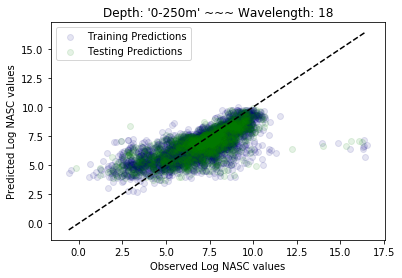

In [28]:
# Predictions and Evalutation
from sklearn.metrics import classification_report,confusion_matrix
from numpy.polynomial.polynomial import polyfit

predictions = mlp.predict(x_train)

# Fit with polyfit
#b, m = polyfit(y_train, predictions, 1)
#plt.plot(y_train, b + m * y_train, '--',alpha=0.5,c='red',label='1-to-1 line')

min_1 = np.min((y_train.min(),y_test.min(),predictions.min()))
max_1 = np.max((y_train.max(),y_test.max(),predictions.max()))
range_1 = np.arange(min_1,max_1)

plt.plot(range_1,range_1,c='k',linestyle='--')
plt.scatter(y_train,predictions,alpha = 0.1,c='navy',label='Training Predictions')
plt.scatter(y_test,mlp.predict(x_test),alpha = 0.1, c = 'green',label='Testing Predictions')
plt.title(f"Depth: {depths[0]} ~~~ Wavelength: {wavelengths[0]}")
plt.xlabel('Observed Log NASC values')
plt.ylabel('Predicted Log NASC values')
plt.legend()

plt.show()

In [1]:
# create figure looping through wavelengths (18,38,70,120,200), and depths (0-250,250-500,500-750)

def biomass_models(path,depths,wavelengths):
    
    # import libraries
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import classification_report,confusion_matrix
    from numpy.polynomial.polynomial import polyfit
    from sklearn.metrics import r2_score
    
    full_csv = pd.read_csv(path)
    full_csv = full_csv.query('NASC > 0')  # filter out zero-value NASC
    full_csv = full_csv.assign(log_nasc = np.log(full_csv.NASC))  # log transform of NASC
    full_csv = full_csv.query('log_nasc < 17.5')
    
    #### subset columns & filter out NaN values & subset into training data
    z = full_csv[['Lat','Lon','log_nasc','closest_sst', 'closest_chlor_a','distance_from_shore_m','depth_m',\
                  'closest_poc','closest_nflh','closest_Rrs_412','closest_Rrs_443','closest_Rrs_469',\
                  'closest_Rrs_488','closest_Rrs_531','closest_Rrs_547','closest_Rrs_555','closest_Rrs_645',\
                  'closest_Rrs_667','closest_Rrs_678']]
    z = z.dropna()
    x = z.drop('log_nasc',axis=1) # all features except NASC biomass
    y = z['log_nasc']             # proxy biomass
    r2_train_list = []
    r2_test_list = []
    
    for j in range(len(wavelengths)):
        full_csv = full_csv.query(f"wavelength == {wavelengths[j]}" ) # loop through wavelengths
        
        fig, ax = plt.subplots(1,3, figsize=(20,10),facecolor='w', edgecolor='k',sharey=True,sharex=True)
        ax = ax.ravel()
        
        for i in range(len(depths)):
            full_csv = full_csv.query(f"depth_bin == {depths[i]}")  # loop through depths using f-string
            
            x_train, x_test, y_train, y_test = train_test_split(x,y)
            
            ### Scale data
            scaler = StandardScaler()
            scaler.fit(x_train) # Fit only to the training data
            StandardScaler(copy=True, with_mean=True, with_std=True)
            # Now apply the transformations to the data:
            x_train = scaler.transform(x_train)
            x_test = scaler.transform(x_test)
            
            ### MLP Regressor
            mlp = MLPRegressor(hidden_layer_sizes=(20,20,20,20,20),max_iter=100000)
            mlp.fit(x_train, y_train)
            
            ### Predictions & Evaluation
            predictions = mlp.predict(x_train)
        
            r2_train = r2_score(y_train,predictions)  # r coefficient for training data
            r2_train_list.append(r2_train)
            r2_test = r2_score(y_test,mlp.predict(x_test))  # r coefficient for testing data
            r2_test_list.append(r2_test)
    
            min_1 = np.min((y_train.min(),y_test.min(),predictions.min()))
            max_1 = np.max((y_train.max(),y_test.max(),predictions.max()))
            range_1 = np.arange(-2.5,12.5)

            ### loop through plots for all wavelengths
            ax[i].plot(range_1,range_1, '--',c='red',alpha=0.6,label='1-to-1 line')
            ax[i].scatter(y_train,predictions,alpha = 0.1,c='navy',label='Training Predictions')
            ax[i].scatter(y_test,mlp.predict(x_test),alpha = 0.1, c = 'green',label='Testing Predictions')
            ax[i].set_title(f"Depth: {depths[i]} ~ Wavelength: {wavelengths[j]}kHz\n---------------------\n$R^2$ (train): {r2_train}\n$R^2$ (test): {r2_test}",\
                           fontsize=15)
            
        plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5),fancybox=True,shadow=True,fontsize='xx-large')
        fig.text(0.5,0.04,'Observed Log NASC values',ha='center',fontsize=20) # x common label
        fig.text(0.04,0.5,'Predicted Log NASC values',va='center',rotation='vertical',fontsize=20)  # common y label
        #plt.savefig('NN_modeloutput_'+str(wavelengths[j])+'.png')
        plt.show()

    return r2_train_list,r2_test_list

In [2]:
# function inputs
path = "/users/kellie/Documents/A College Life ^_^/CU Boulder/Earthlab - Analytics Hub/\
sonar_project/sonar-demo-master/sonar-demo-master/4km_sonardata/nasc_sonar.csv"
wavelengths = ["18","38","70","120","200"]
depths = ["'0-250m'","'250-500m'","'500-750m'"] # double quotes need for query syntax

r2_train_model_0,r2_test_model_0 = biomass_models(path,depths,wavelengths)

<Figure size 2000x1000 with 3 Axes>

<Figure size 2000x1000 with 3 Axes>

<Figure size 2000x1000 with 3 Axes>

<Figure size 2000x1000 with 3 Axes>

<Figure size 2000x1000 with 3 Axes>

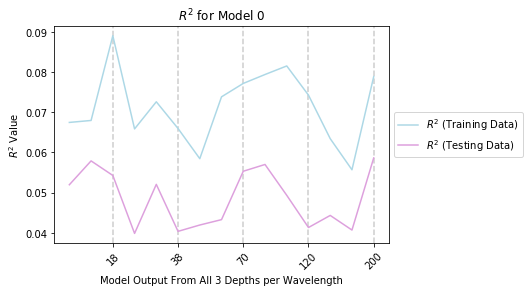

In [38]:
# plotting R-coefficients for this model (model 0)

xlabels = ['18','38','70','120','200']

xcoords = [2, 5, 8, 11, 14]  # where function moves through wavelengths
for xc in xcoords:
    plt.axvline(x=xc,linestyle='--',c='k',alpha=0.2)
    

plt.plot(r2_train_model_0,label='$R^2$ (Training Data)',c='lightblue')
plt.plot(r2_test_model_0,label='$R^2$ (Testing Data)',c='plum')
plt.title('$R^2$ for Model 0')
plt.ylabel('$R^2$ Value')
plt.xticks(np.linspace(2,14,5), ['18','38','70','120','200'], rotation=45)
plt.xlabel('Model Output From All 3 Depths per Wavelength')
plt.legend(loc = 'center left',bbox_to_anchor=(1.0, 0.5))
plt.savefig('$R^2$ Comparison for Model 0.png')
plt.show()

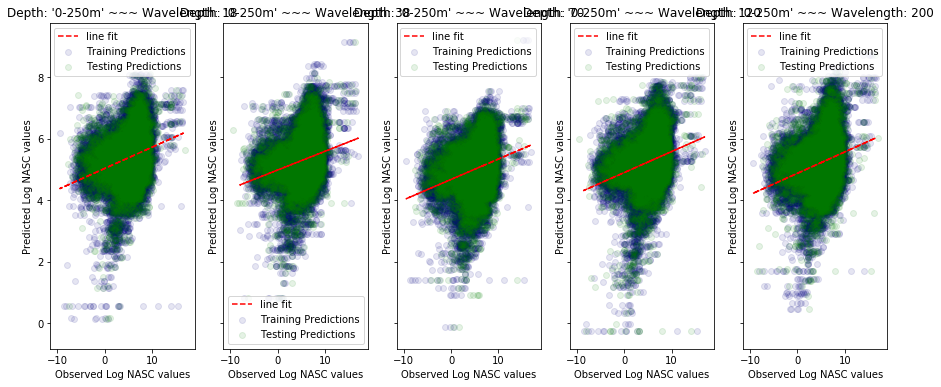

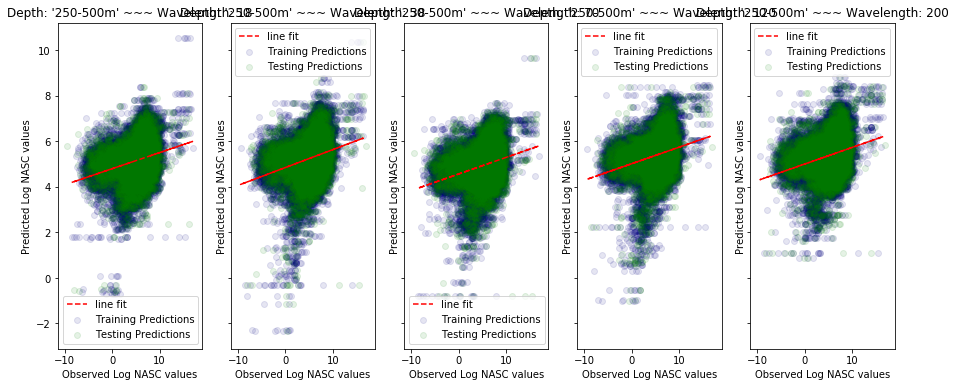

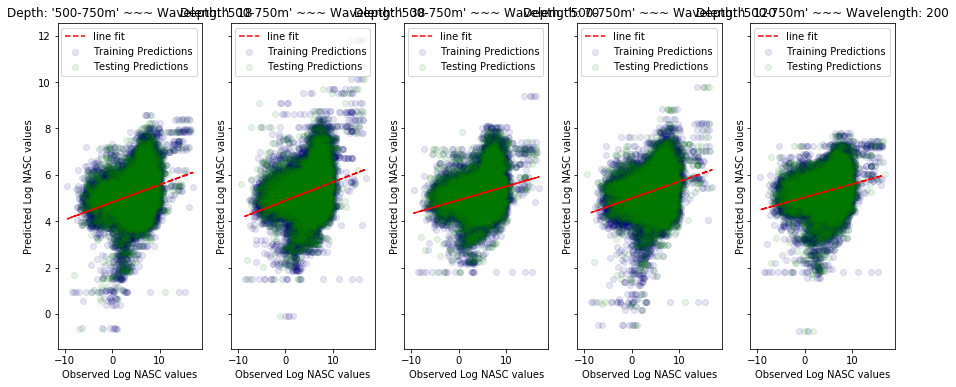

In [4]:
# function inputs
path = "/users/kellie/Documents/A College Life ^_^/CU Boulder/Earthlab - Analytics Hub/\
sonar_project/sonar-demo-master/sonar-demo-master/4km_sonardata/nasc_sonar.csv"
wavelengths = ["18","38","70","120","200"]
depths = ["'0-250m'","'250-500m'","'500-750m'"] # double quotes need for query syntax

biomass_models(path,depths,wavelengths)

930816
51712


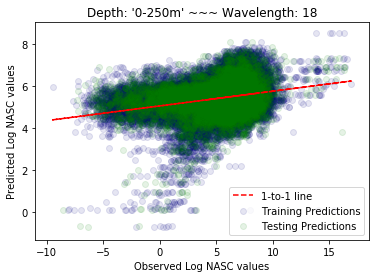

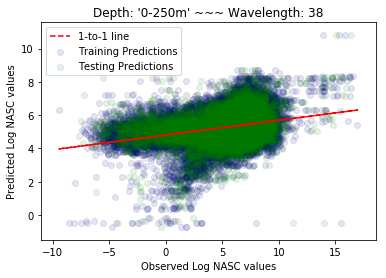

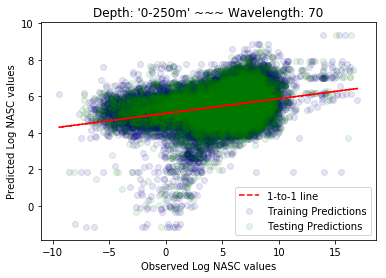

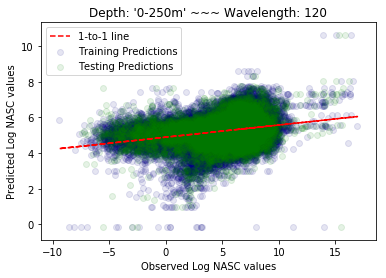

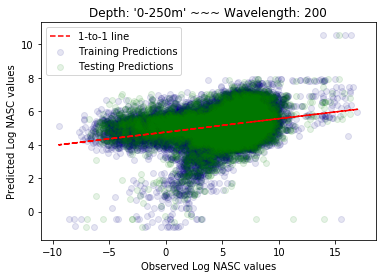

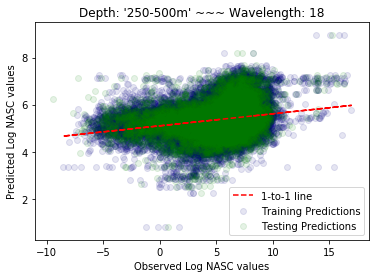

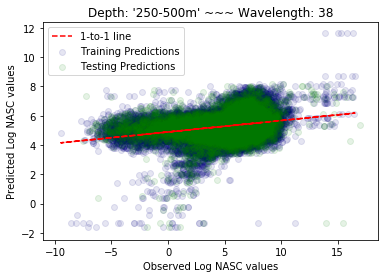

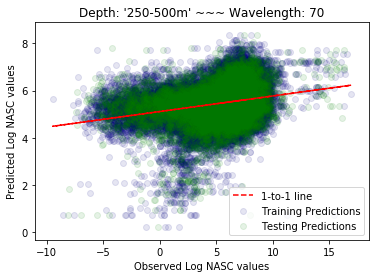

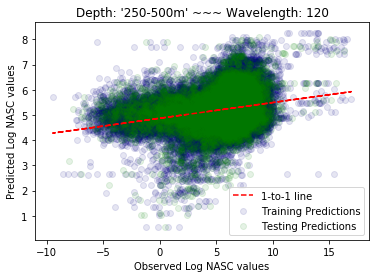

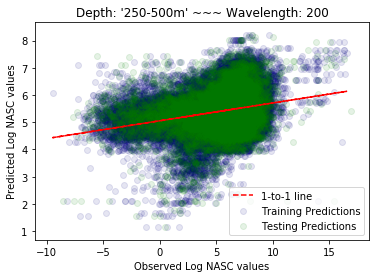

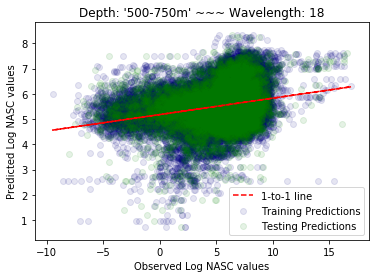

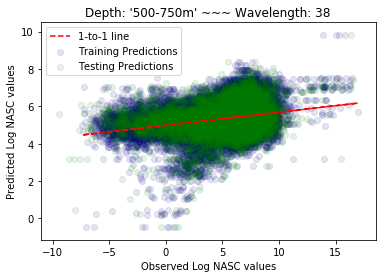

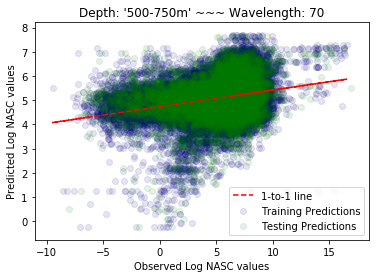

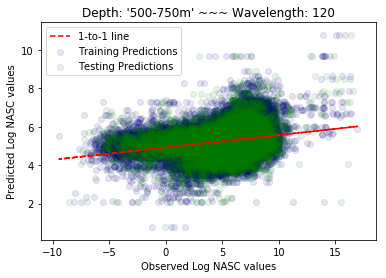

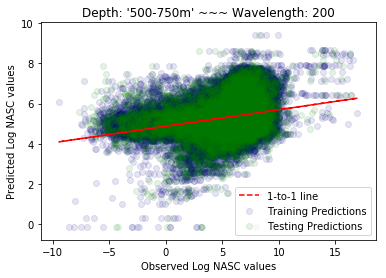

In [72]:
# function inputs --> old plots
path = "/users/kellie/Documents/A College Life ^_^/CU Boulder/Earthlab - Analytics Hub/\
sonar_project/sonar-demo-master/sonar-demo-master/4km_sonardata/nasc_sonar.csv"
wavelengths = ["18","38","70","120","200"]
depths = ["'0-250m'","'250-500m'","'500-750m'"] # double quotes need for query syntax

biomass_models(path,depths,wavelengths)
